In [ ]:
# ============================================================================
# Auto-regressive sampler for the real-valued EquiJumpCore
# ============================================================================

import torch, healpy as hp, numpy as np, matplotlib.pyplot as plt, math, pickle
from dataset import (HealpixSequenceDataset, collate_complex,
                             merge_coeffs, unnorm_healpix_alms_final)
from utils import real_to_complex_channel_stack, CONFIG_KEYS                             # NEW
from interpolant_train import EquiJumpDiT, gamma_dot         # uses real model
from interpolant_train import gamma_tau                       # reuse

# ---------- 0. Paths & constants -------------------------------------------
ckpt          = "lipidgen_best_vanilla.pt"
stats_file    = "sh_norm_stats_correct.pkl"
val_file      = "dummy_folders_val.txt"
root_path     = "."

N_STEPS_GEN   = 19          # 20-frame trajectory (start + 19 preds)
start_frame    = 10     # <-- choose any 0 ≤ start_frame ≤ T-N_STEPS_GEN
SDE_STEPS     = 100         # inner Euler steps
PLOT_INTERVAL = 5

LMAX_RADIAL   = 14
LMAX_FG       = 22
LMAX_BG       = 44
NSIDE_RADIAL  = 16
NSIDE_PHASE   = 16
N_MAPS        = 3
N_FG_CLASSES  = 3

# ---------- 1.  Dataset and stats -------------------------------------------
all_stats = pickle.load(open(stats_file, "rb"))
val_folds = [ln.strip() for ln in open(val_file) if ln.strip()]
ds_val    = HealpixSequenceDataset(root_path, val_folds, stats_path=stats_file)

rng   = np.random.default_rng()
idx   = rng.integers(len(ds_val))
traj  = ds_val[idx]
T     = traj["radial"].shape[0]
print(f"Sampled trajectory {idx} with {T} frames.")

# ---------- 2.  Build model dimensions --------------------------------------
def nC(arr): return arr.shape[1] * arr.shape[2]          # C_real × M

rad_dim = nC(traj["radial"])
fg_dim  = nC(traj["fg"])
bg_dim  = nC(traj["bg"])
dims    = (rad_dim, fg_dim, bg_dim)
D       = rad_dim + fg_dim + bg_dim
P       = len(CONFIG_KEYS)

device  = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- 3.  Assemble first frame & conditioning -------------------------
seq   = torch.cat([merge_coeffs(traj[k].unsqueeze(0))
                   for k in ["radial","fg","bg"]], 2).to(device)   # (1,T,D)
cond  = traj["cond"].unsqueeze(0).to(device)                       # (1,P)

x0 = seq[:, start_frame]             # (1, D)

# -------- 4. Instantiate *compiled* model and load checkpoint -------------
ckpt_path = "lipidgen.pt"
ckpt      = torch.load(ckpt_path, map_location=device)       # disk → RAM (dict)

# 1) build the raw model
net_raw = EquiJumpDiT(D, cond_dim=P, dims=dims).to(device)

# 2) wrap it with torch.compile  (this adds the `_orig_mod.` prefix internally)
net = torch.compile(net_raw, mode="reduce-overhead", fullgraph=False)

# 3) load — keys in the file already start with "_orig_mod."
state = ckpt["model_state"] if "model_state" in ckpt else ckpt
net.load_state_dict(state, strict=True)          # no mismatch!

net.eval()
print("✅ compiled model loaded")


# ---------- 5.  Auto-regressive generation ---------------------------------
eps_const = 1.0
states = [x0]

for step in range(N_STEPS_GEN):
    x_t = states[-1]                                   # (1,1,D)
    X   = torch.zeros(SDE_STEPS+1, 1, D, device=device)  # real
    X[0] = x_t.unsqueeze(0)
    taus = torch.linspace(1e-4, 1.0-1/SDE_STEPS, SDE_STEPS, device=device).unsqueeze(-1).unsqueeze(-1)
    #taus = torch.clamp(taus, 0.05, 0.95)
    

    with torch.no_grad():
        for k, tau in enumerate(taus):
            x_tau = X[k]                       # (1, D)
            x_tau3d = x_tau.unsqueeze(1)       # (1, 1, D)
            z_tau   = torch.randn_like(x_tau3d)

            b_hat, eta_hat = net(
                x_t=x_t.unsqueeze(1),      # Shape (1, 1, D)
                x_tau=x_tau3d,             # Shape (1, 1, D)
                cfg=cond,                  # Shape (1, P)
                tau=tau                    # Shape (1, 1), which is correct
            )

            gamma = gamma_tau(tau)
            drift = (b_hat.squeeze(1) -
                    (eps_const / gamma) * eta_hat.squeeze(1)) / SDE_STEPS
            diff  = math.sqrt(2 * eps_const) * z_tau.squeeze(1)   # back to (1,D)

            X[k+1] = x_tau + drift + diff        # (1, D)
    bn_frame = states[-1].norm().item()
    print(f"  ► frame {step+1:02d}/{N_STEPS_GEN} generated  |  ‖X‖₂ = {bn_frame}")
    
    states.append(X[-1])

print("Generation finished.")
# ==============================================================================
# 6. Setup for Reconstruction & Plotting (CORRECTED)
# ==============================================================================
# These Lmax and Nside values should match your simulation parameters
LMAX_RADIAL = 14
LMAX_PHASE_FG = 22
LMAX_PHASE_BG = 44
NSIDE_RADIAL = 16
NSIDE_PHASE = 16

# These should match the channel counts in your data
N_PHASE_MAPS = 3
N_FG_CLASSES_PER_MAP = 3

# --- CORRECTED: Calculate sizes for BOTH complex (pos-m) and real basis vectors ---
C_pos_RADIAL = hp.Alm.getsize(LMAX_RADIAL)
C_pos_FG     = hp.Alm.getsize(LMAX_PHASE_FG)
C_pos_BG     = hp.Alm.getsize(LMAX_PHASE_BG)

C_real_RADIAL = (LMAX_RADIAL + 1)**2 + (LMAX_RADIAL + 1)
C_real_FG     = (LMAX_PHASE_FG + 1)**2 + (LMAX_PHASE_FG + 1)
C_real_BG     = (LMAX_PHASE_BG + 1)**2 + (LMAX_PHASE_BG + 1)

# --- CORRECTED: Define slicing indices based on the REAL vector sizes ---
start_idx_rad = 0
end_idx_rad   = start_idx_rad + C_real_RADIAL

start_idx_fg  = end_idx_rad
end_idx_fg    = start_idx_fg + C_real_FG * N_PHASE_MAPS * N_FG_CLASSES_PER_MAP

start_idx_bg  = end_idx_fg
end_idx_bg    = start_idx_bg + C_real_BG * N_PHASE_MAPS


def reconstruct_all_maps(state_vec_gpu, stats_dict):
    """
    REVAMPED: Takes a real-valued SH basis state vector from the model,
    converts each component back to complex Alm, un-normalizes, and creates maps.
    """
    maps = {}
    state_vec = state_vec_gpu.cpu().numpy().squeeze(0) # Remove batch dim, move to CPU

    # ---- 1. Reconstruct Radial Map ----
    # a) Slice the real-basis vector for the radial component
    radial_real_coeffs = torch.from_numpy(state_vec[start_idx_rad:end_idx_rad])
    
    ### FIX 1: Reshape the 1D radial vector to the expected 3D shape (1, C, 2*M) ###
    # For the radial map, T=1, M=1. The shape is (1, 120, 2).
    radial_real_coeffs_3d = radial_real_coeffs.reshape(1, C_pos_RADIAL, 2)

    # b) Convert from real basis back to complex Alm
    radial_cplx_coeffs_norm = real_to_complex_channel_stack(radial_real_coeffs_3d)
    print(f"Radial coeffs shape: {radial_cplx_coeffs_norm.shape}")  # Should be (1, C_pos_RADIAL, 2)
    
    radial_coeffs_orig = unnorm_healpix_alms_final(radial_cplx_coeffs_norm, stats_dict["radial"])[0, :, 0]
    
    # d) Create map
    maps['radial'] = hp.alm2map(radial_coeffs_orig.astype(np.complex128), nside=NSIDE_RADIAL, lmax=LMAX_RADIAL)

    # ---- 2. Reconstruct Phase Maps ----
    # a) Slice the real-basis vectors for fg and bg components
    fg_real_flat = state_vec[start_idx_fg:end_idx_fg]
    bg_real_flat = state_vec[start_idx_bg:end_idx_bg]

    # b) Reshape them back to (C_real, M) format
    # Note: The C_real... calculations are a bit misleading but the total size is correct.
    fg_real_coeffs = fg_real_flat.reshape(-1, N_PHASE_MAPS * N_FG_CLASSES_PER_MAP)
    bg_real_coeffs = bg_real_flat.reshape(-1, N_PHASE_MAPS)

    fg_maps, bg_maps = [], []
    for i in range(N_PHASE_MAPS):
        # Process background map for this channel
        bg_real_vec = torch.from_numpy(bg_real_coeffs[:, i])
        
        ### FIX 2: Reshape the 1D background vector to the expected 3D shape ###
        bg_real_vec_3d = bg_real_vec.reshape(1, C_pos_BG, 2)
        bg_cplx_norm = real_to_complex_channel_stack(bg_real_vec_3d)

        bg_cplx_orig = unnorm_healpix_alms_final(bg_cplx_norm, stats_dict["phase_bg"])[0, :, 0]
        bg_maps.append(hp.alm2map(bg_cplx_orig.astype(np.complex128), nside=NSIDE_PHASE, lmax=LMAX_PHASE_BG).real)

        # Process all foreground classes for this channel
        for j in range(N_FG_CLASSES_PER_MAP):
            ch_idx = i * N_FG_CLASSES_PER_MAP + j
            fg_real_vec = torch.from_numpy(fg_real_coeffs[:, ch_idx])
            
            ### FIX 3: Reshape the 1D foreground vector to the expected 3D shape ###
            fg_real_vec_3d = fg_real_vec.reshape(1, C_pos_FG, 2)
            fg_cplx_norm = real_to_complex_channel_stack(fg_real_vec_3d)

            fg_cplx_orig = unnorm_healpix_alms_final(fg_cplx_norm, stats_dict["phase_fg"])[0, :, 0]
            fg_maps.append(hp.alm2map(fg_cplx_orig.astype(np.complex128), nside=NSIDE_PHASE, lmax=LMAX_PHASE_FG).real)

    # Build argmax composite (UNCHANGED)
    for i in range(N_PHASE_MAPS):
        component_list = [bg_maps[i]] + fg_maps[i*N_FG_CLASSES_PER_MAP:(i+1)*N_FG_CLASSES_PER_MAP]
        maps[f'phase_{i+1}'] = np.argmax(np.stack(component_list, axis=0), axis=0).astype(float)
        
    return maps

# ==============================================================================
# 7. Collect Frames and Reconstruct
# ==============================================================================
states_to_plot = []
titles_to_plot = []

# Add the start frame
states_to_plot.append(states[0])
titles_to_plot.append(f"Start (t={start_frame})")

# Add intermediate predictions
for i in range(1, N_STEPS_GEN):
    if (i + 1) % PLOT_INTERVAL == 0:
        states_to_plot.append(states[i])
        titles_to_plot.append(f"Pred. (t={start_frame + i})")

# Add the final prediction
states_to_plot.append(states[-1])
titles_to_plot.append(f"Final Pred. (t={start_frame + N_STEPS_GEN})")

# Add the final ground truth for comparison
# Note: seq from the dataloader is already in the real SH basis
truth_frame_to_plot = seq[:, start_frame + N_STEPS_GEN]
states_to_plot.append(truth_frame_to_plot)
titles_to_plot.append(f"Truth (t={start_frame + N_STEPS_GEN})")


print("\nReconstructing maps for visualization...")
all_maps_to_plot = [reconstruct_all_maps(state, all_stats) for state in states_to_plot]
print("✅ Reconstruction finished.")


# ==============================================================================
# 8. Plot the Evolution Grid (Your preferred plotting code)
# ==============================================================================
N_COLS = len(all_maps_to_plot)
N_ROWS = 4 # One for radial, three for phase
fig = plt.figure(figsize=(4 * N_COLS, 4 * N_ROWS))
fig.suptitle(f"Auto-Regressive Evolution over {N_STEPS_GEN} Steps", fontsize=20, y=1.0)

maps_of_interest = ['radial', 'phase_1', 'phase_2', 'phase_3']
# Corrected titles to match your previous style
map_titles = ["Radial", "Phase 1", "Phase 2", "Phase 3"]

for i, map_type in enumerate(maps_of_interest): # Loop over rows
    sequence_of_maps = [m[map_type] for m in all_maps_to_plot]
    
    vmin, vmax = 0, N_FG_CLASSES_PER_MAP # Phase maps have a fixed range
    # Create a consistent color range for the radial map across all plots

    #if map_type == 'radial':
    #    vmin = min(np.min(m.real) for m in sequence_of_maps)
    #    vmax = max(np.max(m.real) for m in sequence_of_maps)

    for j, (map_to_plot, col_title) in enumerate(zip(sequence_of_maps, titles_to_plot)): # Loop over columns
        panel_idx = i * N_COLS + j + 1
        title = f"{map_titles[i]}\n{col_title}"
        plot_kwargs = {'fig': fig, 'sub': (len(maps_of_interest), N_COLS, panel_idx), 'title': title, 'cmap': 'viridis'}

        if map_type == 'radial':
            # --- before plotting each radial map (inside the loop) -------------------
            mp = np.nan_to_num(map_to_plot.real, nan=0.0, posinf=0.0, neginf=0.0)
            vmin, vmax = mp.min(), mp.max()          # guaranteed finite
            hp.mollview(map_to_plot, min=vmin, max=vmax, **plot_kwargs)
        else:
            hp.mollview(map_to_plot, min=vmin, max=vmax, **plot_kwargs)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Sampled trajectory 1 with 101 frames.
✅ compiled model loaded


CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.
CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.
W0613 12:28:46.450000 4140 site-packages/torch/_inductor/u

  ► frame 01/19 generated  |  ‖X‖₂ = 66.80243682861328


/home/tim/anaconda3/envs/deepsphere_env/lib/python3.10/site-packages/torch/cuda/graphs.py:84: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:175.)
  super().capture_end()
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x766bd99abcd0>>
Traceback (most recent call last):
  File "/home/tim/anaconda3/envs/deepsphere_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Sampled trajectory 5 with 101 frames.
✅ plain model loaded
  ► frame 01/19 generated  |  ‖X‖₂ = 73.58708953857422
  ► frame 02/19 generated  |  ‖X‖₂ = 4992.11962890625
  ► frame 03/19 generated  |  ‖X‖₂ = 7425.09375
  ► frame 04/19 generated  |  ‖X‖₂ = 9465.80859375
  ► frame 05/19 generated  |  ‖X‖₂ = 11505.2685546875
  ► frame 06/19 generated  |  ‖X‖₂ = 13531.458984375
  ► frame 07/19 generated  |  ‖X‖₂ = 15477.5576171875
  ► frame 08/19 generated  |  ‖X‖₂ = 17412.892578125
  ► frame 09/19 generated  |  ‖X‖₂ = 19224.1640625
  ► frame 10/19 generated  |  ‖X‖₂ = 21099.962890625
  ► frame 11/19 generated  |  ‖X‖₂ = 22979.97265625
  ► frame 12/19 generated  |  ‖X‖₂ = 24901.51953125
  ► frame 13/19 generated  |  ‖X‖₂ = 26775.203125
  ► frame 14/19 generated  |  ‖X‖₂ = 28603.796875
  ► frame 15/19 generated  |  ‖X‖₂ = 30607.6796875
  ► frame 16/19 generated  |  ‖X‖₂ = 32494.5234375
  ► frame 17/19 generated  |  ‖X‖₂ = 34338.51171875
  ► frame 18/19 generated  |  ‖X‖₂ = 36275.19921875
  ► f

/tmp/ipykernel_1049152/3662613688.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


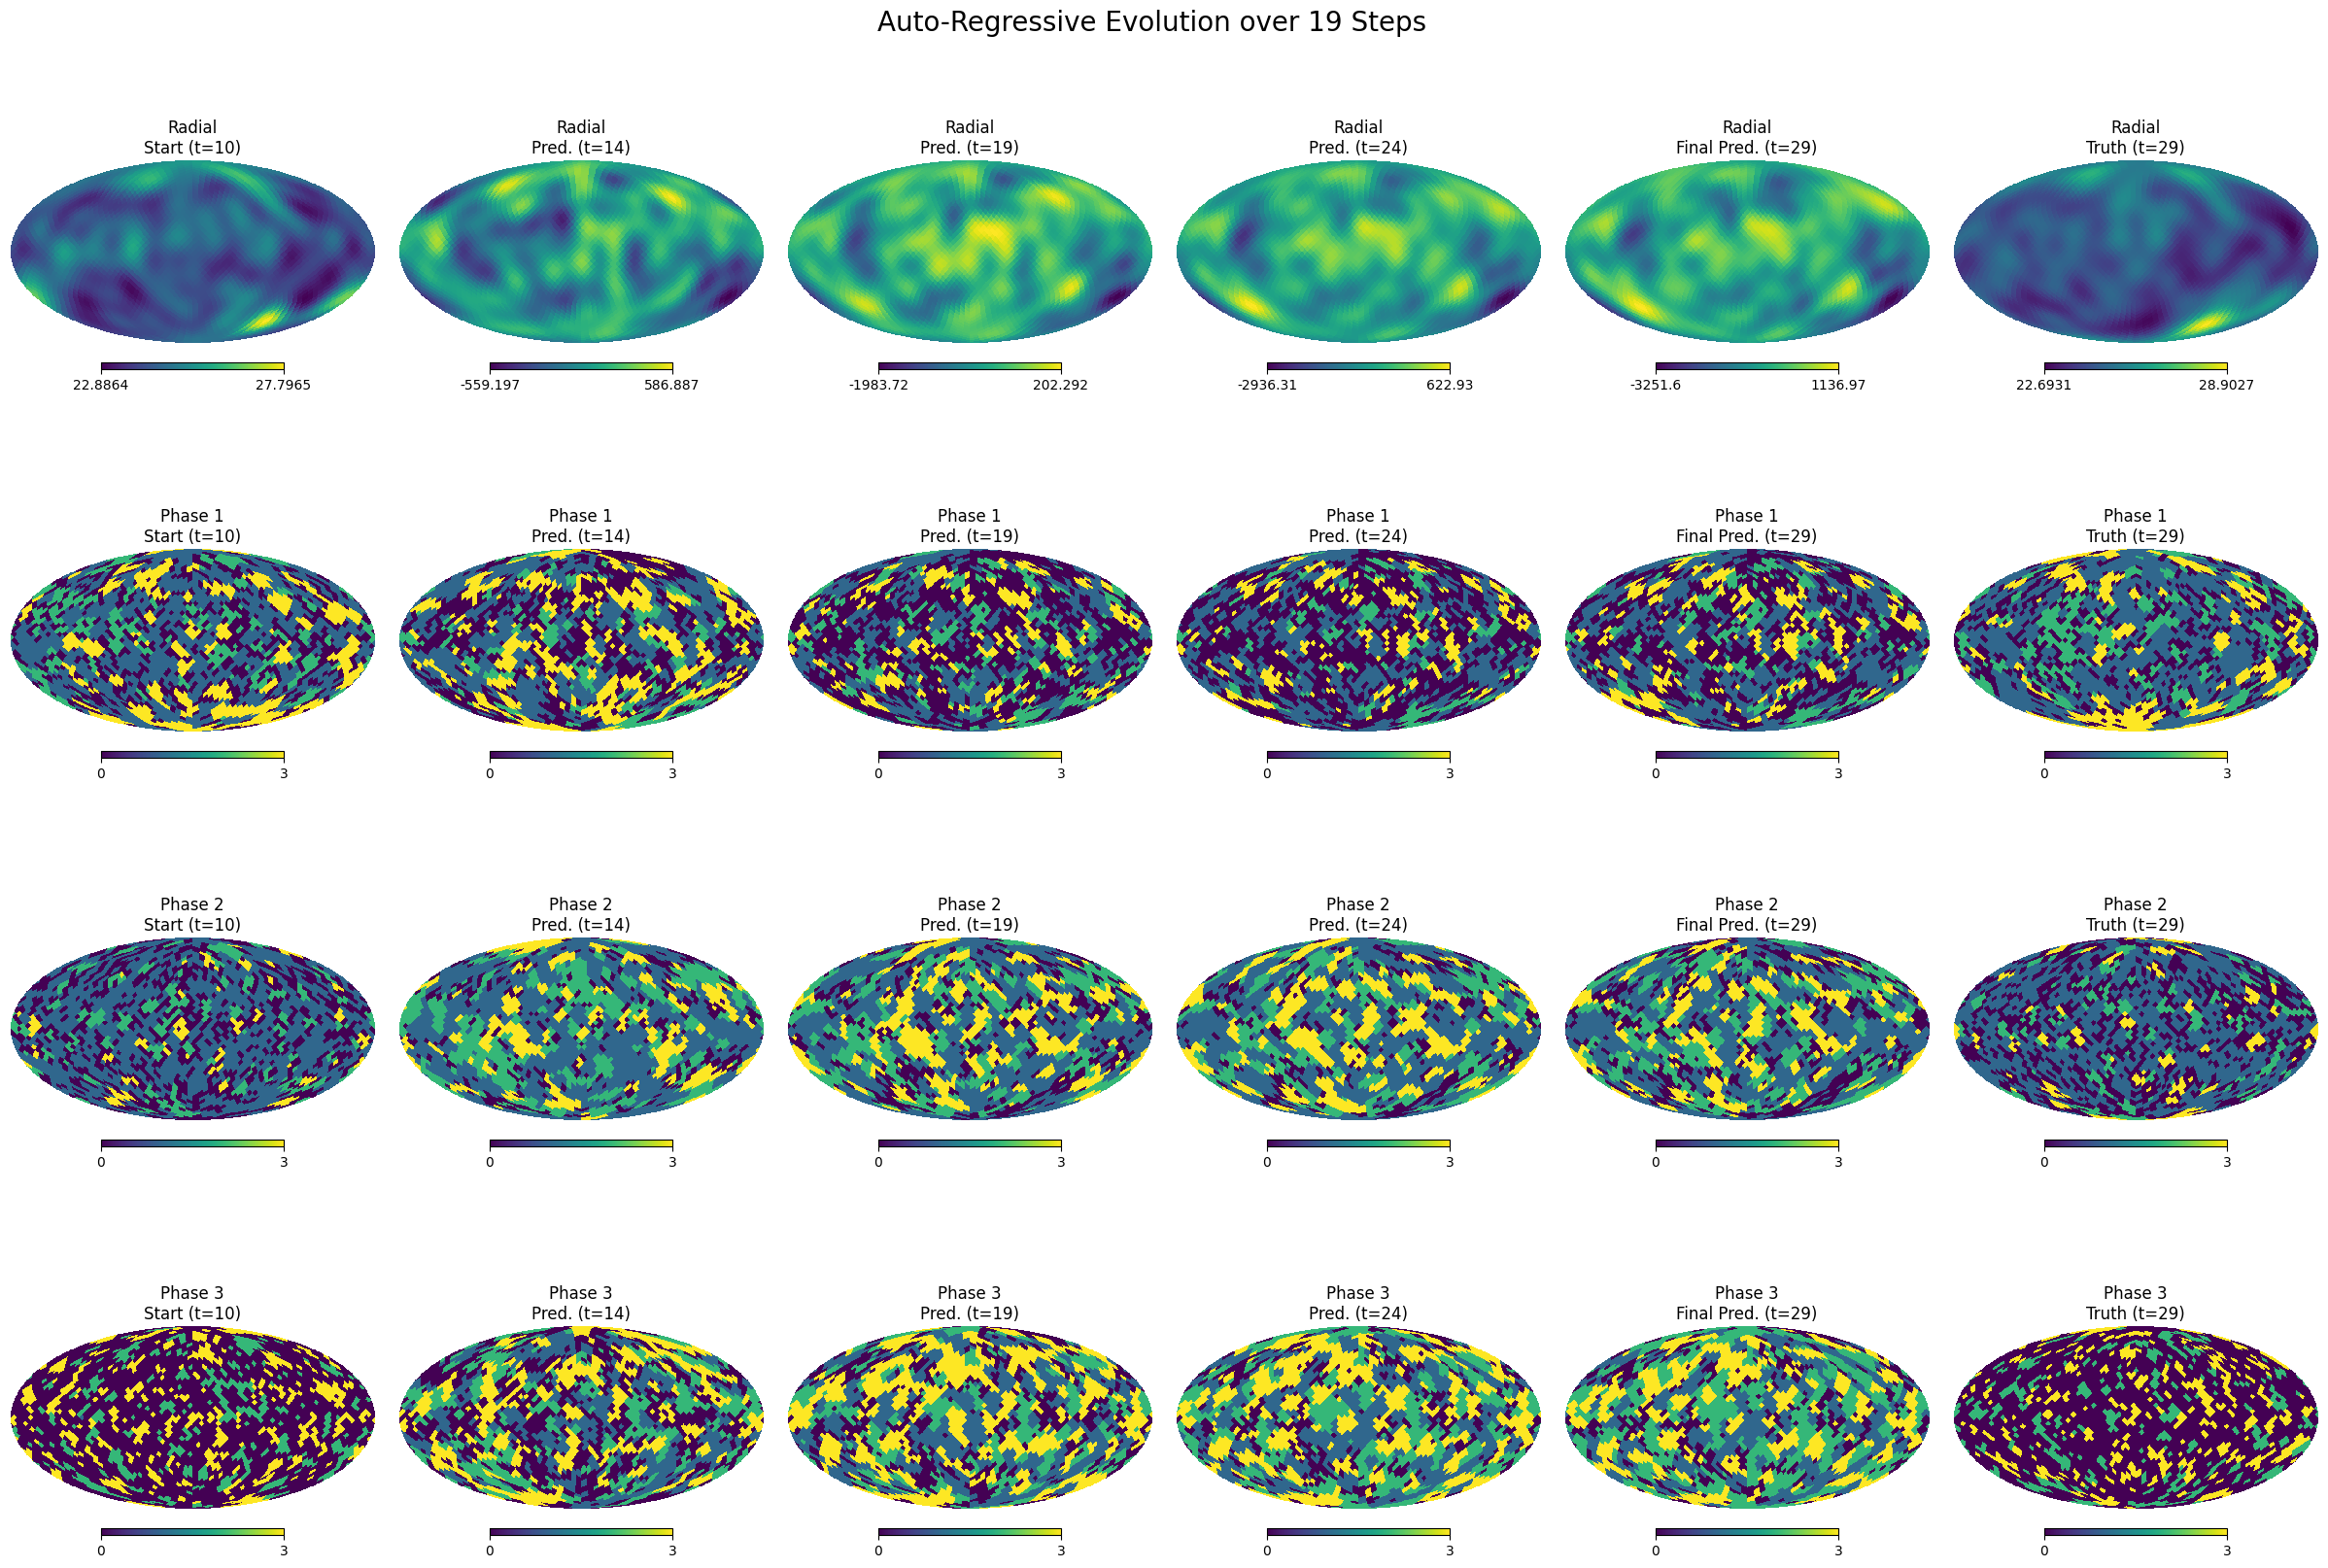

In [ ]:
# ============================================================================
# Auto-regressive sampler for the real-valued EquiJumpCore
# ============================================================================

import torch, healpy as hp, numpy as np, matplotlib.pyplot as plt, math, pickle
from dataset import (HealpixSequenceDataset, collate_complex,
                             merge_coeffs, unnorm_healpix_alms_final)
from utils import real_to_complex_channel_stack, CONFIG_KEYS                             # NEW
from interpolant_1x import EquiJumpDiT, gamma_dot         # uses real model
from interpolant_1x import gamma_tau                       # reuse

# ---------- 0. Paths & constants -------------------------------------------
#ckpt          = "lipidgen.pt"
stats_file    = "sh_norm_stats_correct.pkl"
val_file      = "dummy_folders_val.txt"
root_path     = "."

N_STEPS_GEN   = 19          # 20-frame trajectory (start + 19 preds)
start_frame    = 10     # <-- choose any 0 ≤ start_frame ≤ T-N_STEPS_GEN
SDE_STEPS     = 1000         # inner Euler steps
PLOT_INTERVAL = 5

LMAX_RADIAL   = 14
LMAX_FG       = 22
LMAX_BG       = 44
NSIDE_RADIAL  = 16
NSIDE_PHASE   = 16
N_MAPS        = 3
N_FG_CLASSES  = 3

# ---------- 1.  Dataset and stats -------------------------------------------
all_stats = pickle.load(open(stats_file, "rb"))
val_folds = [ln.strip() for ln in open(val_file) if ln.strip()]
ds_val    = HealpixSequenceDataset(root_path, val_folds, stats_path=stats_file)

rng   = np.random.default_rng()
idx   = rng.integers(len(ds_val))
traj  = ds_val[idx]
T     = traj["radial"].shape[0]
print(f"Sampled trajectory {idx} with {T} frames.")

# ---------- 2.  Build model dimensions --------------------------------------
def nC(arr): return arr.shape[1] * arr.shape[2]          # C_real × M

rad_dim = nC(traj["radial"])
fg_dim  = nC(traj["fg"])
bg_dim  = nC(traj["bg"])
dims    = (rad_dim, fg_dim, bg_dim)
D       = rad_dim + fg_dim + bg_dim
P       = len(CONFIG_KEYS)

device  = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- 3.  Assemble first frame & conditioning -------------------------
seq   = torch.cat([merge_coeffs(traj[k].unsqueeze(0))
                   for k in ["radial","fg","bg"]], 2).to(device)   # (1,T,D)
cond  = traj["cond"].unsqueeze(0).to(device)                       # (1,P)

x0 = seq[:, start_frame]             # (1, D)

# -------- 4. Instantiate *plain* model and load checkpoint ---------------
ckpt_path = "lipidgen_best_big_0rots.pt"
ckpt      = torch.load(ckpt_path, map_location=device)

# 1) build the *plain* (non-compiled) model
net = EquiJumpDiT(D, cond_dim=P, dims=dims).to(device)

# 2) fetch the state-dict and drop the wrapper prefix if present
state = ckpt["model_state"] if "model_state" in ckpt else ckpt
prefix = "_orig_mod."

if any(k.startswith(prefix) for k in state):              # compiled ckpt?
    state = {k[len(prefix):] if k.startswith(prefix) else k: v
             for k, v in state.items()}

# 3) load
net.load_state_dict(state, strict=True)

net.eval()
print("✅ plain model loaded")



# ---------- 5.  Auto-regressive generation ---------------------------------
eps_const = 1.0
states = [x0]

for step in range(N_STEPS_GEN):
    x_t = states[-1]                                   # (1,1,D)
    X   = torch.zeros(SDE_STEPS+1, 1, D, device=device)  # real
    X[0] = x_t.unsqueeze(0)
    CLAMP_MIN = 1e-4 # Or a similar small value
    taus = torch.linspace(CLAMP_MIN, 1.0 - CLAMP_MIN, SDE_STEPS, device=device).unsqueeze(-1).unsqueeze(-1)
    #taus = torch.clamp(taus, 0.05, 0.95)
    

    with torch.no_grad():
        for k, tau in enumerate(taus):
            x_tau = X[k]                       # (1, D)
            x_tau3d = x_tau.unsqueeze(1)       # (1, 1, D)
            z_tau   = torch.randn_like(x_tau3d)

            b_hat, eta_hat = net(
                x_t=x_t.unsqueeze(1),      # Shape (1, 1, D)
                x_tau=x_tau3d,             # Shape (1, 1, D)
                cfg=cond,                  # Shape (1, P)
                tau=tau                    # Shape (1, 1), which is correct
            )

            gamma = gamma_tau(tau)
            drift = (b_hat.squeeze(1) -
                    (eps_const / gamma) * eta_hat.squeeze(1)) / SDE_STEPS
            diff  = math.sqrt(2 * eps_const) * z_tau.squeeze(1)   # back to (1,D)

            X[k+1] = x_tau + drift + diff        # (1, D)
    bn_frame = states[-1].norm().item()
    print(f"  ► frame {step+1:02d}/{N_STEPS_GEN} generated  |  ‖X‖₂ = {bn_frame}")
    
    states.append(X[-1])

print("Generation finished.")
# ==============================================================================
# 6. Setup for Reconstruction & Plotting (CORRECTED)
# ==============================================================================
# These Lmax and Nside values should match your simulation parameters
LMAX_RADIAL = 14
LMAX_PHASE_FG = 22
LMAX_PHASE_BG = 44
NSIDE_RADIAL = 16
NSIDE_PHASE = 16

# These should match the channel counts in your data
N_PHASE_MAPS = 3
N_FG_CLASSES_PER_MAP = 3

# --- CORRECTED: Calculate sizes for BOTH complex (pos-m) and real basis vectors ---
C_pos_RADIAL = hp.Alm.getsize(LMAX_RADIAL)
C_pos_FG     = hp.Alm.getsize(LMAX_PHASE_FG)
C_pos_BG     = hp.Alm.getsize(LMAX_PHASE_BG)

C_real_RADIAL = (LMAX_RADIAL + 1)**2 + (LMAX_RADIAL + 1)
C_real_FG     = (LMAX_PHASE_FG + 1)**2 + (LMAX_PHASE_FG + 1)
C_real_BG     = (LMAX_PHASE_BG + 1)**2 + (LMAX_PHASE_BG + 1)

# --- CORRECTED: Define slicing indices based on the REAL vector sizes ---
start_idx_rad = 0
end_idx_rad   = start_idx_rad + C_real_RADIAL

start_idx_fg  = end_idx_rad
end_idx_fg    = start_idx_fg + C_real_FG * N_PHASE_MAPS * N_FG_CLASSES_PER_MAP

start_idx_bg  = end_idx_fg
end_idx_bg    = start_idx_bg + C_real_BG * N_PHASE_MAPS


def reconstruct_all_maps(state_vec_gpu, stats_dict):
    """
    REVAMPED: Takes a real-valued SH basis state vector from the model,
    converts each component back to complex Alm, un-normalizes, and creates maps.
    """
    maps = {}
    state_vec = state_vec_gpu.cpu().numpy().squeeze(0) # Remove batch dim, move to CPU

    # ---- 1. Reconstruct Radial Map ----
    # a) Slice the real-basis vector for the radial component
    radial_real_coeffs = torch.from_numpy(state_vec[start_idx_rad:end_idx_rad])
    
    ### FIX 1: Reshape the 1D radial vector to the expected 3D shape (1, C, 2*M) ###
    # For the radial map, T=1, M=1. The shape is (1, 120, 2).
    radial_real_coeffs_3d = radial_real_coeffs.reshape(1, C_pos_RADIAL, 2)

    # b) Convert from real basis back to complex Alm
    radial_cplx_coeffs_norm = real_to_complex_channel_stack(radial_real_coeffs_3d)
    print(f"Radial coeffs shape: {radial_cplx_coeffs_norm.shape}")  # Should be (1, C_pos_RADIAL, 2)
    
    radial_coeffs_orig = unnorm_healpix_alms_final(radial_cplx_coeffs_norm, stats_dict["radial"])[0, :, 0]
    
    # d) Create map
    maps['radial'] = hp.alm2map(radial_coeffs_orig.astype(np.complex128), nside=NSIDE_RADIAL, lmax=LMAX_RADIAL)

    # ---- 2. Reconstruct Phase Maps ----
    # a) Slice the real-basis vectors for fg and bg components
    fg_real_flat = state_vec[start_idx_fg:end_idx_fg]
    bg_real_flat = state_vec[start_idx_bg:end_idx_bg]

    # b) Reshape them back to (C_real, M) format
    # Note: The C_real... calculations are a bit misleading but the total size is correct.
    fg_real_coeffs = fg_real_flat.reshape(-1, N_PHASE_MAPS * N_FG_CLASSES_PER_MAP)
    bg_real_coeffs = bg_real_flat.reshape(-1, N_PHASE_MAPS)

    fg_maps, bg_maps = [], []
    for i in range(N_PHASE_MAPS):
        # Process background map for this channel
        bg_real_vec = torch.from_numpy(bg_real_coeffs[:, i])
        
        ### FIX 2: Reshape the 1D background vector to the expected 3D shape ###
        bg_real_vec_3d = bg_real_vec.reshape(1, C_pos_BG, 2)
        bg_cplx_norm = real_to_complex_channel_stack(bg_real_vec_3d)

        bg_cplx_orig = unnorm_healpix_alms_final(bg_cplx_norm, stats_dict["phase_bg"])[0, :, 0]
        bg_maps.append(hp.alm2map(bg_cplx_orig.astype(np.complex128), nside=NSIDE_PHASE, lmax=LMAX_PHASE_BG).real)

        # Process all foreground classes for this channel
        for j in range(N_FG_CLASSES_PER_MAP):
            ch_idx = i * N_FG_CLASSES_PER_MAP + j
            fg_real_vec = torch.from_numpy(fg_real_coeffs[:, ch_idx])
            
            ### FIX 3: Reshape the 1D foreground vector to the expected 3D shape ###
            fg_real_vec_3d = fg_real_vec.reshape(1, C_pos_FG, 2)
            fg_cplx_norm = real_to_complex_channel_stack(fg_real_vec_3d)

            fg_cplx_orig = unnorm_healpix_alms_final(fg_cplx_norm, stats_dict["phase_fg"])[0, :, 0]
            fg_maps.append(hp.alm2map(fg_cplx_orig.astype(np.complex128), nside=NSIDE_PHASE, lmax=LMAX_PHASE_FG).real)

    # Build argmax composite (UNCHANGED)
    for i in range(N_PHASE_MAPS):
        component_list = [bg_maps[i]] + fg_maps[i*N_FG_CLASSES_PER_MAP:(i+1)*N_FG_CLASSES_PER_MAP]
        maps[f'phase_{i+1}'] = np.argmax(np.stack(component_list, axis=0), axis=0).astype(float)
        
    return maps

# ==============================================================================
# 7. Collect Frames and Reconstruct
# ==============================================================================
states_to_plot = []
titles_to_plot = []

# Add the start frame
states_to_plot.append(states[0])
titles_to_plot.append(f"Start (t={start_frame})")

# Add intermediate predictions
for i in range(1, N_STEPS_GEN):
    if (i + 1) % PLOT_INTERVAL == 0:
        states_to_plot.append(states[i])
        titles_to_plot.append(f"Pred. (t={start_frame + i})")

# Add the final prediction
states_to_plot.append(states[-1])
titles_to_plot.append(f"Final Pred. (t={start_frame + N_STEPS_GEN})")

# Add the final ground truth for comparison
# Note: seq from the dataloader is already in the real SH basis
truth_frame_to_plot = seq[:, start_frame + N_STEPS_GEN]
states_to_plot.append(truth_frame_to_plot)
titles_to_plot.append(f"Truth (t={start_frame + N_STEPS_GEN})")


print("\nReconstructing maps for visualization...")
all_maps_to_plot = [reconstruct_all_maps(state, all_stats) for state in states_to_plot]
print("✅ Reconstruction finished.")


# ==============================================================================
# 8. Plot the Evolution Grid (Your preferred plotting code)
# ==============================================================================
N_COLS = len(all_maps_to_plot)
N_ROWS = 4 # One for radial, three for phase
fig = plt.figure(figsize=(4 * N_COLS, 4 * N_ROWS))
fig.suptitle(f"Auto-Regressive Evolution over {N_STEPS_GEN} Steps", fontsize=20, y=1.0)

maps_of_interest = ['radial', 'phase_1', 'phase_2', 'phase_3']
# Corrected titles to match your previous style
map_titles = ["Radial", "Phase 1", "Phase 2", "Phase 3"]

for i, map_type in enumerate(maps_of_interest): # Loop over rows
    sequence_of_maps = [m[map_type] for m in all_maps_to_plot]
    
    vmin, vmax = 0, N_FG_CLASSES_PER_MAP # Phase maps have a fixed range
    # Create a consistent color range for the radial map across all plots

    #if map_type == 'radial':
    #    vmin = min(np.min(m.real) for m in sequence_of_maps)
    #    vmax = max(np.max(m.real) for m in sequence_of_maps)

    for j, (map_to_plot, col_title) in enumerate(zip(sequence_of_maps, titles_to_plot)): # Loop over columns
        panel_idx = i * N_COLS + j + 1
        title = f"{map_titles[i]}\n{col_title}"
        plot_kwargs = {'fig': fig, 'sub': (len(maps_of_interest), N_COLS, panel_idx), 'title': title, 'cmap': 'viridis'}

        if map_type == 'radial':
            # --- before plotting each radial map (inside the loop) -------------------
            mp = np.nan_to_num(map_to_plot.real, nan=0.0, posinf=0.0, neginf=0.0)
            vmin, vmax = mp.min(), mp.max()          # guaranteed finite
            hp.mollview(map_to_plot, min=vmin, max=vmax, **plot_kwargs)
        else:
            hp.mollview(map_to_plot, min=vmin, max=vmax, **plot_kwargs)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# ============================================================================
# Auto-regressive sampler for the real-valued EquiJumpCore
# ============================================================================

import torch, healpy as hp, numpy as np, matplotlib.pyplot as plt, math, pickle
from dataset import (HealpixSequenceDataset, collate_complex,
                             merge_coeffs, unnorm_healpix_alms_final)
from utils import real_to_complex_channel_stack, CONFIG_KEYS                             # NEW
from interpolant_1xbig import EquiJumpDiT, gamma_dot         # uses real model
from interpolant_1xbig import gamma_tau                       # reuse
import logging
import warnings

logging.getLogger('healpy').setLevel(logging.WARNING)

# 2. Silence matplotlib UserWarning
# Ignores all warnings of type UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- 0. Paths & constants -------------------------------------------
#ckpt          = "lipidgen.pt"
stats_file    = "sh_norm_stats_correct.pkl"
val_file      = "dummy_folders_val.txt"
root_path     = "."

N_STEPS_GEN   = 30          # 20-frame trajectory (start + 19 preds)
start_frame    = 10     # <-- choose any 0 ≤ start_frame ≤ T-N_STEPS_GEN
SDE_STEPS     = 100         # inner Euler steps
PLOT_INTERVAL = 10

LMAX_RADIAL   = 14
LMAX_FG       = 22
LMAX_BG       = 44
NSIDE_RADIAL  = 16
NSIDE_PHASE   = 16
N_MAPS        = 3
N_FG_CLASSES  = 3

# ---------- 1.  Dataset and stats -------------------------------------------
all_stats = pickle.load(open(stats_file, "rb"))
val_folds = [ln.strip() for ln in open(val_file) if ln.strip()]
ds_val    = HealpixSequenceDataset(root_path, val_folds, stats_path=stats_file)

rng   = np.random.default_rng()
idx   = rng.integers(len(ds_val))
idx = 4
traj  = ds_val[idx]
T     = traj["radial"].shape[0]
print(f"Sampled trajectory {idx} with {T} frames.")

# ---------- 2.  Build model dimensions --------------------------------------
def nC(arr): return arr.shape[1] * arr.shape[2]          # C_real × M

rad_dim = nC(traj["radial"])
fg_dim  = nC(traj["fg"])
bg_dim  = nC(traj["bg"])
dims    = (rad_dim, fg_dim, bg_dim)
D       = rad_dim + fg_dim + bg_dim
P       = len(CONFIG_KEYS)

device  = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- 3.  Assemble first frame & conditioning -------------------------
seq   = torch.cat([merge_coeffs(traj[k].unsqueeze(0))
                   for k in ["radial","fg","bg"]], 2).to(device)   # (1,T,D)
cond  = traj["cond"].unsqueeze(0).to(device)                       # (1,P)

x0 = seq[:, start_frame]             # (1, D)

# -------- 4. Instantiate *plain* model and load checkpoint ---------------
ckpt_path = "interpolant_results/lipidgen_best_big_0rots_very_big.pt"
ckpt      = torch.load(ckpt_path, map_location=device)

# 1) build the *plain* (non-compiled) model
net = EquiJumpDiT(D, cond_dim=P, dims=dims).to(device)

# 2) fetch the state-dict and drop the wrapper prefix if present
state = ckpt["model_state"] if "model_state" in ckpt else ckpt
prefix = "_orig_mod."

if any(k.startswith(prefix) for k in state):              # compiled ckpt?
    state = {k[len(prefix):] if k.startswith(prefix) else k: v
             for k, v in state.items()}

# 3) load
net.load_state_dict(state, strict=True)

net.eval()
print("✅ plain model loaded")



# ---------- 5.  Auto-regressive generation ---------------------------------
eps_const = 1.0
states = [x0]

for step in range(N_STEPS_GEN):
    x_t = states[-1]                                   # (1,1,D)
    X   = torch.zeros(SDE_STEPS+1, 1, D, device=device)  # real
    X[0] = x_t.unsqueeze(0)
    CLAMP_MIN = 0.0005 # Or a similar small value
    taus = torch.linspace(0, 1.0, SDE_STEPS, device=device).unsqueeze(-1).unsqueeze(-1)
    #taus = torch.clamp(taus, 0.05, 0.95)
    

    with torch.no_grad():
        for k, tau in enumerate(taus):
            x_tau = X[k]                       # (1, D)
            x_tau3d = x_tau.unsqueeze(1)       # (1, 1, D)
            z_tau   = torch.randn_like(x_tau3d)

            b_hat, eta_hat = net(
                x_t=x_t.unsqueeze(1),      # Shape (1, 1, D)
                x_tau=x_tau3d,             # Shape (1, 1, D)
                cfg=cond,                  # Shape (1, P)
                tau=tau                    # Shape (1, 1), which is correct
            )

            gamma = gamma_tau(tau)
            noise_modulator = 1.2 * eps_const / (gamma + 0.05)

            
            drift = (b_hat.squeeze(1) -
                    noise_modulator * eta_hat.squeeze(1)) / SDE_STEPS
            
            #drift = (b_hat.squeeze(1) - 10* gamma *
            #        eta_hat.squeeze(1)) / SDE_STEPS
            
            sigma = 0.10 * drift.norm(dim=-1, keepdim=True) / math.sqrt(D)
            z_tau = torch.randn_like(x_tau) * sigma

            diff  = math.sqrt(2 * eps_const) * z_tau.squeeze(1)   # back to (1,D)

            # --- <<< NEW: DIAGNOSTIC PRINTING >>> ---
            if k % 10 == 0:
                # Calculate the L2 norm of the full drift and diffusion vectors
                drift_norm = torch.linalg.norm(drift).item()
                bhat_norm = torch.linalg.norm(b_hat.squeeze(1)).item()
                etahat_norm = torch.linalg.norm(eta_hat.squeeze(1)).item()
                diffusion_norm = torch.linalg.norm(diff).item()
                tau_val = tau.item()
                
                # Print the formatted results
                print(f"    ├─ SDE Step {k:03d} (τ={tau_val:.2f}) | Drift Norm: {drift_norm:.6f} | Diffusion Norm: {diffusion_norm:.6f}| Bhat Norm: {bhat_norm:.6f}| Etahat Norm: {etahat_norm:.6f}| Noise modulation: {noise_modulator:.6f} ")
            # --- <<< END NEW BLOCK >>> ---


            X[k+1] = x_tau + drift + diff        # (1, D)
            #normalize
            #target_len = x_tau.norm()
            #X[k+1] *= target_len / (X[k+1].norm() + 1e-9)
    bn_frame = states[-1].norm().item()
    print(f"  ► frame {step+1:02d}/{N_STEPS_GEN} generated  |  ‖X‖₂ = {bn_frame}")
    
    states.append(X[-1])

print("Generation finished.")
# ==============================================================================
# 6. Setup for Reconstruction & Plotting (CORRECTED)
# ==============================================================================
# These Lmax and Nside values should match your simulation parameters
LMAX_RADIAL = 14
LMAX_PHASE_FG = 22
LMAX_PHASE_BG = 44
NSIDE_RADIAL = 16
NSIDE_PHASE = 16

# These should match the channel counts in your data
N_PHASE_MAPS = 3
N_FG_CLASSES_PER_MAP = 3

# --- CORRECTED: Calculate sizes for BOTH complex (pos-m) and real basis vectors ---
C_pos_RADIAL = hp.Alm.getsize(LMAX_RADIAL)
C_pos_FG     = hp.Alm.getsize(LMAX_PHASE_FG)
C_pos_BG     = hp.Alm.getsize(LMAX_PHASE_BG)

C_real_RADIAL = (LMAX_RADIAL + 1)**2 + (LMAX_RADIAL + 1)
C_real_FG     = (LMAX_PHASE_FG + 1)**2 + (LMAX_PHASE_FG + 1)
C_real_BG     = (LMAX_PHASE_BG + 1)**2 + (LMAX_PHASE_BG + 1)

# --- CORRECTED: Define slicing indices based on the REAL vector sizes ---
start_idx_rad = 0
end_idx_rad   = start_idx_rad + C_real_RADIAL

start_idx_fg  = end_idx_rad
end_idx_fg    = start_idx_fg + C_real_FG * N_PHASE_MAPS * N_FG_CLASSES_PER_MAP

start_idx_bg  = end_idx_fg
end_idx_bg    = start_idx_bg + C_real_BG * N_PHASE_MAPS


def reconstruct_all_maps(state_vec_gpu, stats_dict):
    """
    REVAMPED: Takes a real-valued SH basis state vector from the model,
    converts each component back to complex Alm, un-normalizes, and creates maps.
    """
    maps = {}
    state_vec = state_vec_gpu.cpu().numpy().squeeze(0) # Remove batch dim, move to CPU

    # ---- 1. Reconstruct Radial Map ----
    # a) Slice the real-basis vector for the radial component
    radial_real_coeffs = torch.from_numpy(state_vec[start_idx_rad:end_idx_rad])
    
    ### FIX 1: Reshape the 1D radial vector to the expected 3D shape (1, C, 2*M) ###
    # For the radial map, T=1, M=1. The shape is (1, 120, 2).
    radial_real_coeffs_3d = radial_real_coeffs.reshape(1, C_pos_RADIAL, 2)

    # b) Convert from real basis back to complex Alm
    radial_cplx_coeffs_norm = real_to_complex_channel_stack(radial_real_coeffs_3d)
    print(f"Radial coeffs shape: {radial_cplx_coeffs_norm.shape}")  # Should be (1, C_pos_RADIAL, 2)
    
    radial_coeffs_orig = unnorm_healpix_alms_final(radial_cplx_coeffs_norm, stats_dict["radial"])[0, :, 0]
    
    # d) Create map
    maps['radial'] = hp.alm2map(radial_coeffs_orig.astype(np.complex128), nside=NSIDE_RADIAL, lmax=LMAX_RADIAL)

    # ---- 2. Reconstruct Phase Maps ----
    # a) Slice the real-basis vectors for fg and bg components
    fg_real_flat = state_vec[start_idx_fg:end_idx_fg]
    bg_real_flat = state_vec[start_idx_bg:end_idx_bg]

    # b) Reshape them back to (C_real, M) format
    # Note: The C_real... calculations are a bit misleading but the total size is correct.
    fg_real_coeffs = fg_real_flat.reshape(-1, N_PHASE_MAPS * N_FG_CLASSES_PER_MAP)
    bg_real_coeffs = bg_real_flat.reshape(-1, N_PHASE_MAPS)

    fg_maps, bg_maps = [], []
    for i in range(N_PHASE_MAPS):
        # Process background map for this channel
        bg_real_vec = torch.from_numpy(bg_real_coeffs[:, i])
        
        ### FIX 2: Reshape the 1D background vector to the expected 3D shape ###
        bg_real_vec_3d = bg_real_vec.reshape(1, C_pos_BG, 2)
        bg_cplx_norm = real_to_complex_channel_stack(bg_real_vec_3d)

        bg_cplx_orig = unnorm_healpix_alms_final(bg_cplx_norm, stats_dict["phase_bg"])[0, :, 0]
        bg_maps.append(hp.alm2map(bg_cplx_orig.astype(np.complex128), nside=NSIDE_PHASE, lmax=LMAX_PHASE_BG).real)

        # Process all foreground classes for this channel
        for j in range(N_FG_CLASSES_PER_MAP):
            ch_idx = i * N_FG_CLASSES_PER_MAP + j
            fg_real_vec = torch.from_numpy(fg_real_coeffs[:, ch_idx])
            
            ### FIX 3: Reshape the 1D foreground vector to the expected 3D shape ###
            fg_real_vec_3d = fg_real_vec.reshape(1, C_pos_FG, 2)
            fg_cplx_norm = real_to_complex_channel_stack(fg_real_vec_3d)

            fg_cplx_orig = unnorm_healpix_alms_final(fg_cplx_norm, stats_dict["phase_fg"])[0, :, 0]
            fg_maps.append(hp.alm2map(fg_cplx_orig.astype(np.complex128), nside=NSIDE_PHASE, lmax=LMAX_PHASE_FG).real)

    # Build argmax composite (UNCHANGED)
    for i in range(N_PHASE_MAPS):
        component_list = [bg_maps[i]] + fg_maps[i*N_FG_CLASSES_PER_MAP:(i+1)*N_FG_CLASSES_PER_MAP]
        maps[f'phase_{i+1}'] = np.argmax(np.stack(component_list, axis=0), axis=0).astype(float)
        
    return maps

# ==============================================================================
# 7. Collect Frames and Reconstruct
# ==============================================================================
states_to_plot = []
titles_to_plot = []

# Add the start frame
states_to_plot.append(states[0])
titles_to_plot.append(f"Start (t={start_frame})")

# Add intermediate predictions
for i in range(1, N_STEPS_GEN):
    if (i + 1) % PLOT_INTERVAL == 0:
        states_to_plot.append(states[i])
        titles_to_plot.append(f"Pred. (t={start_frame + i})")

# Add the final prediction
states_to_plot.append(states[-1])
titles_to_plot.append(f"Final Pred. (t={start_frame + N_STEPS_GEN})")

# Add the final ground truth for comparison
# Note: seq from the dataloader is already in the real SH basis
truth_frame_to_plot = seq[:, start_frame + N_STEPS_GEN]
states_to_plot.append(truth_frame_to_plot)
titles_to_plot.append(f"Truth (t={start_frame + N_STEPS_GEN})")


print("\nReconstructing maps for visualization...")
all_maps_to_plot = [reconstruct_all_maps(state, all_stats) for state in states_to_plot]
print("✅ Reconstruction finished.")


# ==============================================================================
# 8. Plot the Evolution Grid (Your preferred plotting code)
# ==============================================================================
N_COLS = len(all_maps_to_plot)
N_ROWS = 4 # One for radial, three for phase
fig = plt.figure(figsize=(4 * N_COLS, 4 * N_ROWS))
fig.suptitle(f"Auto-Regressive Evolution over {N_STEPS_GEN} Steps", fontsize=20, y=1.0)

maps_of_interest = ['radial', 'phase_1', 'phase_2', 'phase_3']
# Corrected titles to match your previous style
map_titles = ["Radial", "Phase 1", "Phase 2", "Phase 3"]

for i, map_type in enumerate(maps_of_interest): # Loop over rows
    sequence_of_maps = [m[map_type] for m in all_maps_to_plot]
    
    vmin, vmax = 0, N_FG_CLASSES_PER_MAP # Phase maps have a fixed range
    # Create a consistent color range for the radial map across all plots

    #if map_type == 'radial':
    #    vmin = min(np.min(m.real) for m in sequence_of_maps)
    #    vmax = max(np.max(m.real) for m in sequence_of_maps)

    for j, (map_to_plot, col_title) in enumerate(zip(sequence_of_maps, titles_to_plot)): # Loop over columns
        panel_idx = i * N_COLS + j + 1
        title = f"{map_titles[i]}\n{col_title}"
        plot_kwargs = {'fig': fig, 'sub': (len(maps_of_interest), N_COLS, panel_idx), 'title': title, 'cmap': 'viridis'}

        if map_type == 'radial':
            # --- before plotting each radial map (inside the loop) -------------------
            mp = np.nan_to_num(map_to_plot.real, nan=0.0, posinf=0.0, neginf=0.0)
            vmin, vmax = mp.min(), mp.max()          # guaranteed finite
            hp.mollview(map_to_plot, min=vmin, max=vmax, **plot_kwargs)
        else:
            hp.mollview(map_to_plot, min=vmin, max=vmax, **plot_kwargs)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Sampled trajectory 4 with 101 frames.
✅ plain model loaded


TypeError: unsupported format string passed to Tensor.__format__